# Case Study: A/B Testing

## Scenario:
A fast food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the new weekly sales of the new item are recorded for the first four weeks.

## Imports

We will import all the relevant packages to perform this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

And import the dataset from a CSV file. This dataset was taken from Kaggle, please see acknowledgments for full credits.

In [2]:
data = pd.read_csv('WA_Marketing-Campaign.csv')

In [3]:
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


When starting a new analysis, it is always important to familiarize yourself with the data: how many observations we have, the column types, data integrity and so on.

## Preprocessing

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


We have 548 total observations, and we can see that we have no missing values. Every variable is numeric except for Market Size. Everything looks good to proceed. Before that, however, we will rename the column names to conform to snake_case naming conventions.

In [5]:
data = data.rename(columns={'MarketID': 'market_id',
                            'MarketSize': 'market_size',
                            'LocationID': 'location_id',
                            'AgeOfStore': 'age_of_store',
                            'Promotion': 'promotion',
                            'SalesInThousands': 'sales'})
data.columns

Index(['market_id', 'market_size', 'location_id', 'age_of_store', 'promotion',
       'week', 'sales'],
      dtype='object')

## Exploratory Analysis

Now we are ready to proceed with the analysis. Common sense dictates that as the market size increases, the sales should also increase. We are interested to see if that is the case here.

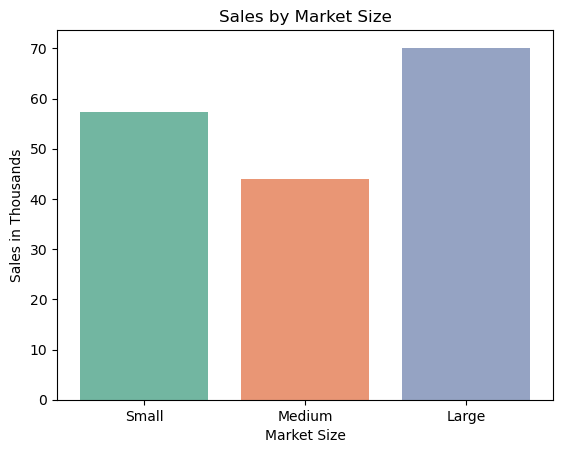

In [6]:
order = ['Small', 'Medium', 'Large']
fig = sns.barplot(x='market_size', y='sales', data=data, errorbar=None, palette='Set2', order=order)
fig.set_title('Sales by Market Size')
fig.set_xlabel('Market Size')
fig.set_ylabel('Sales in Thousands')
fig.plot();

Something interesting is happening. The medium market size shows the lowest sales out of the three groups. Perhaps this is indicative of the effectiveness of each promotion. 

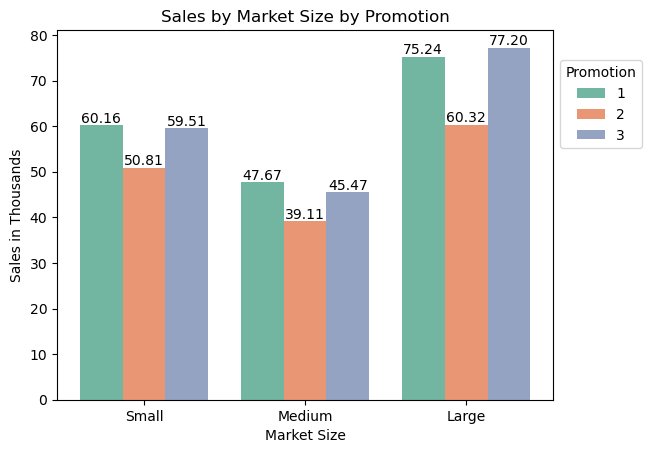

In [7]:
fig = sns.barplot(x='market_size', y='sales', hue='promotion', data=data, errorbar=None, palette='Set2', order=order)
fig.set_title('Sales by Market Size by Promotion')
fig.set_xlabel('Market Size')
fig.set_ylabel('Sales in Thousands')
for p in fig.patches:
    fig.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')
fig.legend(title='Promotion', loc='center left', bbox_to_anchor=(1, 0.8))
fig.plot();

When differentiating for each promotion, we can see that promotion 2 produces the smaller amount of sales. However, promotion 1 and promotion 3 produce similar results, so further analysis is required.

Now, we will explore the effect that the `week` variable has on the overall sales. This might shed some insights on the type of customers that we have.

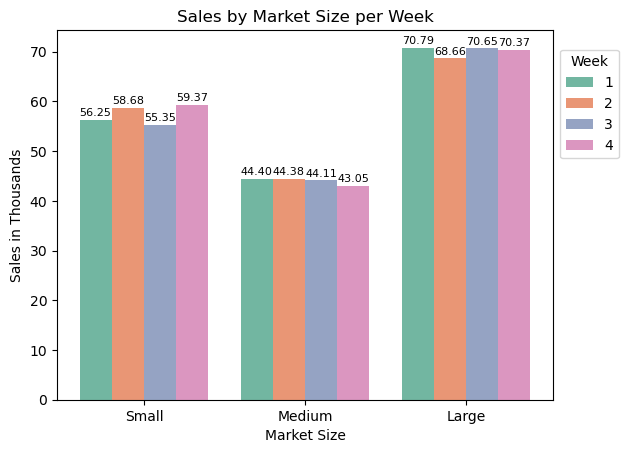

In [8]:
fig = sns.barplot(x='market_size', y='sales', hue='week', data=data, errorbar=None, palette='Set2', order=order)
fig.set_title('Sales by Market Size per Week')
fig.set_xlabel('Market Size')
fig.set_ylabel('Sales in Thousands')

for p in fig.patches:
    fig.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
fig.legend(title='Week', loc='center left', bbox_to_anchor=(1, 0.8))
fig.plot();

On both the medium and large markets, we can see a slight decrease on overall sales as time passes. In the small market, the overall sales level is somewhat irregular. While we found earlier that there is a difference on overall sales depending on the promotion in the small market, this new results might indicate that the concept of a promotion itself might not be indicative of the sales level - perhaps due to low competition in a small market. On the other hand, with more competition in the medium and large market, the effectiveness of a new promotion might wear off as new products hit the market.



## ANOVA

Let's now see if the difference in overall sales by promotion is statistically significant.

Our null hypothesis is that there is no difference in sales based on the type of promotion, and our alternative hypothesis is that there is a difference in sales based on the type of promotion. In other words:
 - $H_0$: $P_1$ = $P_2$ = $P_3$
 - $H_1$: $P_1$ $\neq$ $P_2$ $\neq$ $P_3$ 

We will conduct a one-way ANOVA test:

In [9]:
anova_one_way = stats.f_oneway(data['sales'][data['promotion'] == 1],
                       data['sales'][data['promotion'] == 2],
                       data['sales'][data['promotion'] == 3])
anova_one_way

F_onewayResult(statistic=21.953485793080677, pvalue=6.765849261408714e-10)

We get a p-value of $6.76E^{-10}$, so we can confidently reject the null hypothesis and say that the difference on sales based on the type of promotion is statistically signifcant.

Now, we will check if the market size also has a statistically significant effect on the overall sales level. We are mostly interested in the interaction term between the market size and the promotion type. Our hypothesis are as follow:

#### Null Hypotheses
 1. There is no significant difference in sales across different types of promotions.
 2. There is no significant difference in sales across different market sizes.
 3. There is no significant interaction effect between the type of promotion and the market size on sales.
 
#### Alternative Hypotheses
 1. There is a significant difference in sales across different types of promotions.
 2. There is a significant difference in sales across different market sizes.
 3. There is a significant interaction effect between the type of promotion and the market size on sales.

In [10]:
model = ols('sales ~ C(promotion) + C(market_size) + C(promotion):C(market_size)', data=data).fit()
anova_two_way = sm.stats.anova_lm(model, typ=2)
anova_two_way

,sum_sq,df,F,PR(>F)
C(promotion),12979.270759,2.0,56.241683,6.549744e-23
C(market_size),77803.041539,2.0,337.135582,1.087739e-95
C(promotion):C(market_size),2116.739627,4.0,4.586120,1.194444e-03
Residual,62194.324249,539.0,NaN,NaN


Given the p-values, we can confidently reject the null hypotheses and say that the type of promotion, the market size, and their interaction all have a statistically significant effect on sales.

## A/B Testing

We have concluded that there is a statistically significant effect of the type of promotion and the market size on overall sales level, so we can now determine which type of promotion produces the best results for each market size. 

To do this, we will first check for outliers:

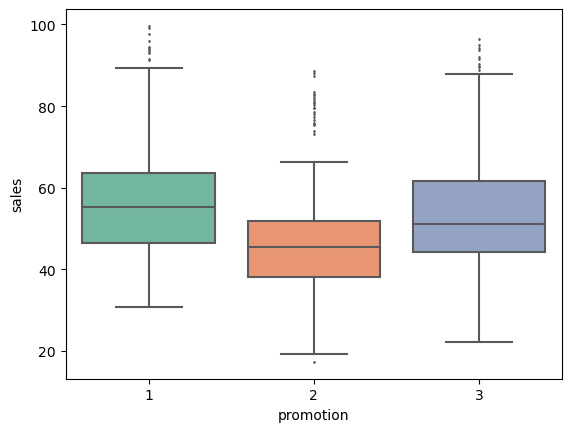

In [11]:
sns.boxplot(x='promotion', y='sales', data=data, palette='Set2', fliersize=1);

We can see that there are outliers across all promotion types. 

We will remove the outliers from our dataframe, because they might be indicative of locations that already show a higher level of sales than the rest, and could diminish our ability to determine which promotion produces the best results for each market size.

We will handle the outliers using the accepted threshold: 
 - Lower limit = 25th percentile - 1.5 * InterQuartileRange
 - Upper Limit = 75th percentile + 1.5 * InterQuartileRange

In [12]:
no_outliers = pd.DataFrame(columns=['market_id', 'market_size', 'location_id', 'age_of_store', 'promotion',
                               'week', 'sales'])
no_outliers

,market_id,market_size,location_id,age_of_store,promotion,week,sales


In [13]:
def remove_outliers(df, promotion, new_df):
    '''Receives:
        - The original dataframe.
        - An integer representing the promotion type.
        - A new dataframe consisting of observation that are not outliers.
       Returns:
        - The new dataframe, which will be used to repeat the process for each promotion type.
    '''
    df = df[df['promotion'] == promotion]
    p25 = df['sales'].quantile(0.25)
    p75 = df['sales'].quantile(0.75)
    iqr = p75 - p25
    lower_limit = p25 - 1.5 * iqr
    upper_limit = p75 + 1.5 * iqr
    outliers = ((df['sales'] > lower_limit) & (df['sales'] < upper_limit))
    remove_outliers = df[outliers]
    new_df = pd.concat([new_df, remove_outliers])
    return new_df

for i in range(1, 4):
    no_outliers = remove_outliers(data, i, no_outliers)

print(f'Total observations:{len(data["sales"])}')
print(f'Observations without outliers:{len(no_outliers["sales"])}')

    
    

Total observations:548
Observations without outliers:502


We have removed 46 observations categorized as outliers by our threshold. Let's replot our boxplot to have final confimation that the process worked:

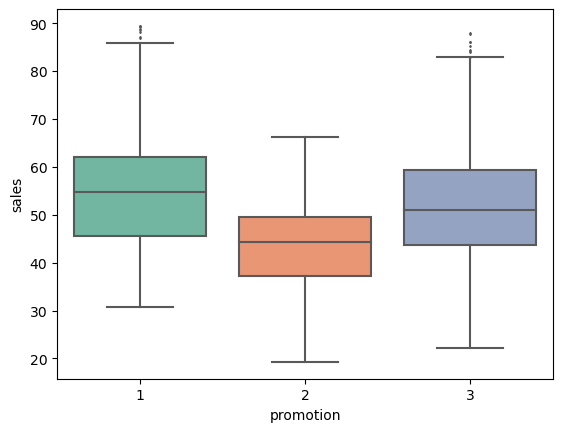

In [14]:
sns.boxplot(x='promotion', y='sales', data=no_outliers, fliersize=1, palette='Set2');

Now that we have no outliers in our dataframe, we can investigate the actual results that each promotion type produces.

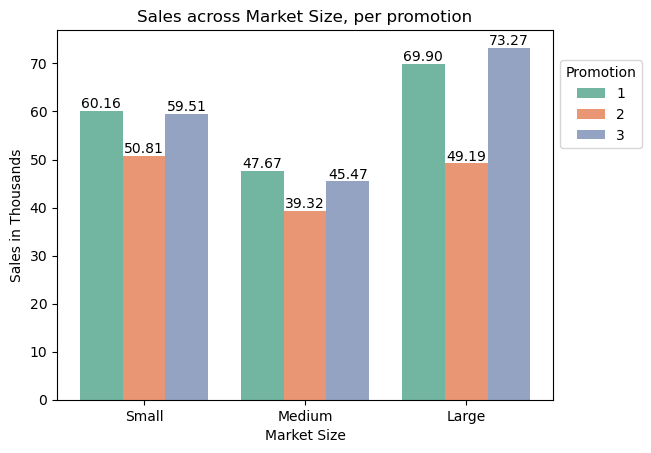

In [15]:
fig = sns.barplot(x='market_size', y='sales', hue='promotion', data=no_outliers, 
            order=order, errorbar=None, palette='Set2')
fig.set_title('Sales across Market Size, per promotion')
fig.set_xlabel('Market Size')
fig.set_ylabel('Sales in Thousands')

for p in fig.patches:
    fig.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
               ha='center', va='center', xytext=(0, 5), textcoords='offset points')
fig.legend(title='Promotion', loc='center left', bbox_to_anchor=(1, 0.8))
fig.plot();


Our initial finding is confirmed: promotion 2 has the worst results across all market sizes.

In the medium market size, promotion 1 seems to produce the best results on sales, by a difference of $2,200$.

In the large market size, promotion 3 has the best results, by a difference of $3,370$.

In the small market size, however, the difference between promotion 1 and promotion 3 is too small to make an accurate conclusion.

Let's investigate the small market size further:

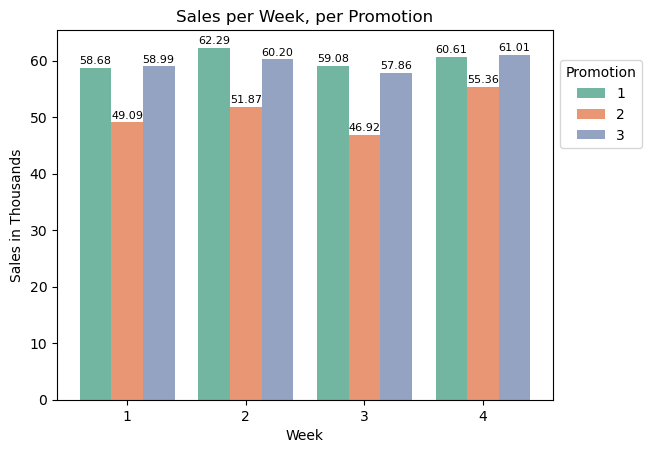

In [16]:
small_market = no_outliers[no_outliers['market_size'] == 'Small']
fig = sns.barplot(x='week', y='sales', hue='promotion', data=small_market, errorbar=None, palette='Set2')
fig.set_title('Sales per Week, per Promotion')
fig.set_xlabel('Week')
fig.set_ylabel('Sales in Thousands')

for p in fig.patches:
    fig.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
fig.legend(title='Promotion', loc='center left', bbox_to_anchor=(1, 0.8))
fig.plot();

Interestingly, promotion 1 performs better in weeks 2 and 3, while promotion 3 performs better in week 1 and 4. Given the limited data that we have, we cannot make a definite conclusion on what promotion works best in the small market, and additional data is required. 

## Conclusion

This analysis was conducted using a one-way and a two-way ANOVA, and then checking for differences in sales using visualizations, while accounting for the difference in market sizes and promotion types.

The main findings are as follow:
 1. Promotion 2 produces the worst results across market types.
 2. On large markets, the best performing promotion is promotion 3.
 3. On medium markets, the best performing promotion is promotion 1.
 4. There is not enough data to accurately determine which promotion works best on small markets.

It is crucial to differentiate between market sizes, as both the potential customers and the existing competition might alter the results. Tailoring each promotion to the existing conditions is paramount for a succesful product launch. 

## References

This dataframe was downloaded from [Kaggle](https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test/data).

IBM Watson Analytics Community is listed as the primary source for this dataset.